### 1. The model used to predict the noise from a sample: a UNet

In [1]:
from diffusers import UNet2DConditionModel

unet_model = UNet2DConditionModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
    ),
    up_block_types=(
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
    block_out_channels=(64, 128, 256),
    cross_attention_dim=512
)

c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A matching Triton is not available, some optimizations will not be enabled
Traceback (most recent call last):
  File "c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\xformers\__init__.py", line 55, in _is_triton_available
    from xformers.triton.softmax import softmax as triton_softmax  # noqa
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\xformers\triton\softmax.py", line 11, in <module>
    import triton
ModuleNotFoundError: No module named 'triton'


In [2]:
# test forward pass
import torch

x = torch.randn(1, 3, 32, 32)
t = torch.randint(0, 1000, (1, ))
y = torch.randn(1, 150, 512)

out = unet_model(x, t, y)
out.sample.shape

torch.Size([1, 3, 32, 32])

### 2. Dataset: Coco captions 2017

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

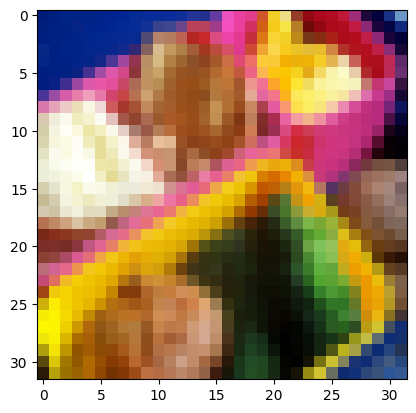

In [4]:
import matplotlib.pyplot as plt
from torchvision.datasets import CocoCaptions
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

dataset = CocoCaptions(
    root="C:/Datasets/coco2017/train2017",
    annFile="C:/Datasets/coco2017/annotations/captions_train2017.json",
    transform=transform,
)

test_img, labels = dataset[0]
test_img = test_img * 0.5 + 0.5
plt.imshow(test_img.permute(1, 2, 0))
labels

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

loading annotations into memory...
Done (t=0.62s)
creating index...
index created!


'there are containers filled with different kinds of foods'

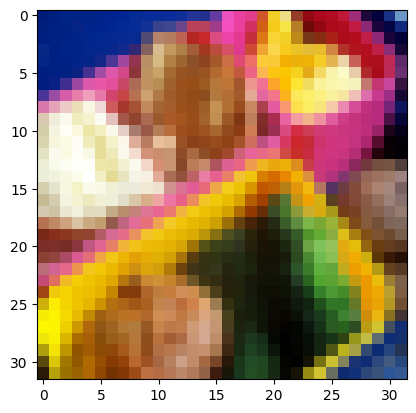

In [64]:
from random import choice

class SigmaDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = CocoCaptions(
            root="C:/Datasets/coco2017/train2017",
            annFile="C:/Datasets/coco2017/annotations/captions_train2017.json",
            transform=transform,
        )

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, text_labels = self.dataset[idx]
        random_text = choice(text_labels)
        return img, random_text
    
sigma_dataset = SigmaDataset(dataset)
test_img, text = sigma_dataset[0]
test_img = test_img * 0.5 + 0.5
plt.imshow(test_img.permute(1, 2, 0))
text

Test noising the image using the diffusers scheduler

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.00971588..1.0093913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3771414..2.0403209].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5682049..2.775539].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.4602633..3.0443883].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7328825..3.2980874].


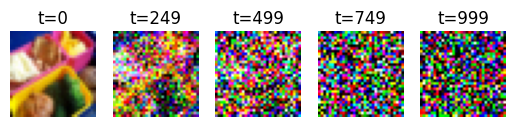

In [65]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
)

noise = torch.randn(5, 3, 32, 32).to(device)
test_batch = test_img.unsqueeze(0).repeat(5, 1, 1, 1).to(device)
timesteps = torch.LongTensor([0, 249, 499, 749, 999])
noised = scheduler.add_noise(test_batch, noise, timesteps)

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(noised[i].cpu().detach().permute(1, 2, 0))
    plt.title(f"t={timesteps[i]}")
    plt.axis("off")

### 3. Text encoder to use for cross attention: CLIP(pretrained)

In [6]:
from transformers import CLIPModel, CLIPTokenizerFast

tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").text_model.requires_grad_(False).to(device)

def encode_text(text):
    with torch.no_grad():
        return model(tokenizer(text, return_tensors="pt").input_ids.to(device)).last_hidden_state
    
def encode_text_batch(texts):
    with torch.no_grad():
        return model(tokenizer(texts, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)).last_hidden_state

In [7]:
encode_text("a photo of a cat")

tensor([[[ 0.3393,  0.1165,  0.1020,  ...,  0.2468,  0.5906,  0.1013],
         [ 1.9753, -0.5844,  0.3685,  ...,  1.1658,  0.8050, -0.9801],
         [ 1.0580, -0.9600,  1.0018,  ..., -0.5155, -0.1437, -1.9444],
         ...,
         [ 0.3059, -1.5037, -0.4022,  ..., -0.0224,  0.9105, -0.3916],
         [ 1.0118, -0.6701,  1.7742,  ..., -0.1556, -0.0250, -1.5062],
         [-0.5152,  0.1658,  0.8876,  ..., -0.0675, -0.4551, -1.7960]]],
       device='cuda:0')

In [10]:
SigmaLoader = DataLoader(sigma_dataset, batch_size=32, shuffle=True)

batch = next(iter(SigmaLoader))
imgs, texts = batch
print(imgs.shape, texts)
text_embeddings = encode_text_batch(texts)
text_embeddings.shape

torch.Size([32, 3, 32, 32]) ('Two cats laying on a table full of objects. ', 'I can see that the hitter just hit the ball.', 'A woman with a camera standing next to a giraffe.', 'Three people are hanging out playing the nintendo wii.', 'a man stands in front of an elephant in a cage', 'A kitchen sink counter covered in cosmetics and bottles.', 'a person taking a photo in a mirror', 'A computer monitor sits upon a make-shift desk in a cluttered room.', 'a cahir is sitting next to a folded umbrella', 'A bright red motorcycle is parked near the woods.', 'A bathroom with a toilet, shower and small vanity sink.', 'A man wearing a suit and tie walking down a street.', 'A huge commercial airplane comes down the runway.', 'A man flying through the air on top of skis.', 'This is an aerial view of West 34th Street.', 'Two hotdogs topped with mustard, one with relish and one with pickles.', 'A microwave is sitting on the dock by the water', 'A couple of people are riding bicycles on the beach. ',

torch.Size([32, 19, 512])

### 4. Training the model

In [66]:
from tqdm import tqdm
from torch import optim

unet_model = UNet2DConditionModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    down_block_types=(
        "DownBlock2D",
        "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D",
    ),
    up_block_types=(
        "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D",
        "UpBlock2D",
    ),
    block_out_channels=(64, 128, 256),
    cross_attention_dim=512
).to(device)
unet_model.load_state_dict(torch.load("unet_model.pt", map_location=device))
SigmaLoader = DataLoader(sigma_dataset, batch_size=128, shuffle=True)
optimizer = optim.Adam(unet_model.parameters(), lr=1e-4)
loss_fn = torch.nn.MSELoss()
NUM_EPOCHS = 20

In [14]:
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}", end=" ")
    pbar = tqdm(SigmaLoader, total=len(SigmaLoader), leave=True)

    for imgs, texts in pbar:
        imgs = imgs.to(device)
        texts = encode_text_batch(texts).to(device)
        noise = torch.randn(imgs.shape).to(device)
        timesteps = torch.randint(0, 1000, (imgs.shape[0], )).to(device)
        noised = scheduler.add_noise(imgs, noise, timesteps)
        optimizer.zero_grad()
        out = unet_model(noised, timesteps, texts)
        loss = loss_fn(out.sample, noise)
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

Epoch 1/20 

100%|██████████| 925/925 [11:44<00:00,  1.31it/s, loss=0.1016]


Epoch 2/20 

100%|██████████| 925/925 [11:05<00:00,  1.39it/s, loss=0.0977]


Epoch 3/20 

100%|██████████| 925/925 [11:00<00:00,  1.40it/s, loss=0.0612]


Epoch 4/20 

100%|██████████| 925/925 [10:59<00:00,  1.40it/s, loss=0.0540]


Epoch 5/20 

100%|██████████| 925/925 [11:10<00:00,  1.38it/s, loss=0.0465]


Epoch 6/20 

100%|██████████| 925/925 [12:39<00:00,  1.22it/s, loss=0.0729]


Epoch 7/20 

100%|██████████| 925/925 [12:49<00:00,  1.20it/s, loss=0.0801]


Epoch 8/20 

100%|██████████| 925/925 [12:33<00:00,  1.23it/s, loss=0.0655]


Epoch 9/20 

100%|██████████| 925/925 [12:32<00:00,  1.23it/s, loss=0.0596]


Epoch 10/20 

100%|██████████| 925/925 [11:46<00:00,  1.31it/s, loss=0.0480]


Epoch 11/20 

  0%|          | 0/925 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [15]:
torch.save(unet_model.state_dict(), "unet_model.pt")

### 5. Using model for inference (actual generation part)

In [67]:
# Inference code
from diffusers import DDIMScheduler

@torch.no_grad()
def model_sample(model, text, scheduler, inference_steps=1000, num_samples=1):
    model.eval()
    text_embedding = encode_text(text).to(device).repeat(num_samples, 1, 1)
    sample = torch.randn(num_samples, 3, 32, 32).to(device)
    scheduler.set_timesteps(inference_steps)

    for t in tqdm(range(999, -1, -(scheduler.num_train_timesteps // inference_steps))):
        sample = scheduler.scale_model_input(sample, t).to(device)
        out = model(sample, torch.LongTensor([t] * num_samples).to(device), text_embedding).sample
        out = scheduler.step(out, t, sample)
        sample = out.prev_sample
        pred_t_0 = out.pred_original_sample

    return sample

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="squaredcos_cap_v2",
)



sample = model_sample(unet_model, "A plate full of food", scheduler, 1000, 25)

c:\Users\enoch\.conda\envs\deeplearn\Lib\site-packages\diffusers\configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
100%|██████████| 1000/1000 [00:18<00:00, 53.68it/s]


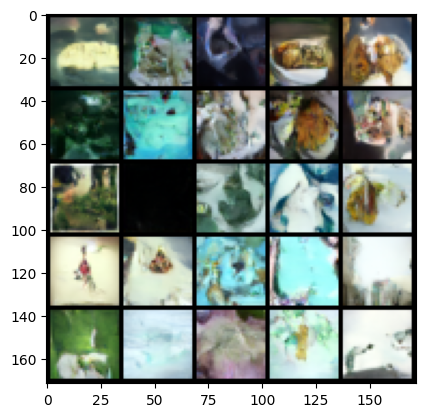

In [68]:
from torchvision.utils import make_grid

sample_grid = make_grid(sample, nrow=5, normalize=True)
plt.imshow(sample_grid.permute(1, 2, 0).cpu().numpy())